# CNN Model Figure Generation

Generate plots from data recorded during training/testing

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from utils import *

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import models

import random
from MacDataset import MacDataset
import macnet
import matplotlib.pyplot as plt
import numpy as np
import uuid

In [2]:
print("Using existing trained model")
net = torch.load('./model')
net.to("cpu")
net.eval()

Using existing trained model


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1a): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In the cell below we load some images from the test dataset and perform predictions.

# Plot Testing/Training Error Curve
Plot the training of the first fold from csv file

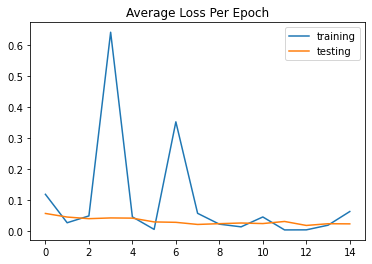

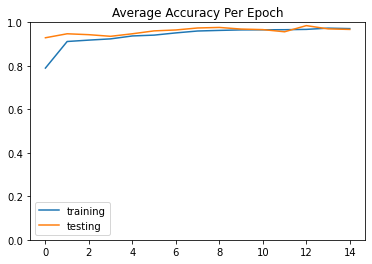

In [3]:
import csv
# https://stackoverflow.com/questions/14091387/creating-a-dictionary-from-a-csv-file
reader = csv.DictReader(open('model_training_history.csv'))

result = {}
for row in reader:
    for column, value in row.items():  # consider .iteritems() for Python 2
        result.setdefault(column, []).append(float(value))

result["epoch"] = [int(i) for i in result["epoch"]]

plt.plot(result["epoch"], result["train_loss"], result["test_loss"])
plt.title("Average Loss Per Epoch")
plt.legend(["training", "testing"])
plt.show()

plt.plot(result["epoch"], result["train_acc"], result["test_acc"])
plt.ylim([0,1])
plt.title("Average Accuracy Per Epoch")
plt.legend(["training", "testing"])
plt.show()

# Confusion Matrix Plotting

https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial

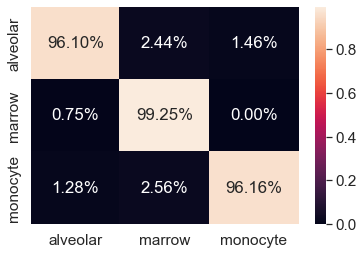

In [6]:
import seaborn as sn
import pandas as pd

matrix = pickle.load(open("model_confusion_matrix.p", "rb"))

axis_labels = ["alveolar", "marrow", "monocyte"]
num_classes = len(axis_labels)
matrix_df = pd.DataFrame(matrix, index=axis_labels, columns=axis_labels)
#matrix_df = pd.DataFrame(matrix, range(3), range(3))
sn.set(font_scale=1.4) # for label size
sn.heatmap(matrix_df, annot=True, fmt='.2%') # font size

plt.show()

# Reciever Operator Characteristic Curve (ROC)


In [29]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

roc_data = pickle.load(open("model_roc_data.p", "rb"))

labels = roc_data["true"]
labels = torch.flatten(torch.stack(labels))
labels_b = label_binarize(labels, classes=[0,1,2])

outputs = roc_data["outputs"]
outputs = torch.flatten(torch.stack(outputs), end_dim=1)
outputs = np.array(torch.softmax(outputs, 1))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_b[:, i], outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(labels_b.ravel(), outputs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




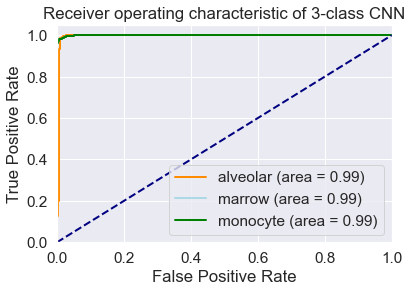

In [31]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='alveolar (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[1], tpr[1], color='lightblue',
         lw=lw, label='marrow (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[1], tpr[1], color='green',
         lw=lw, label='monocyte (area = %0.2f)' % roc_auc[2])                  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of 3-class CNN')
plt.legend(loc="lower right")
plt.show()